In [4]:
name = "Ricardo Hideki Hangai Kojo"  # write YOUR NAME

honorPledge = "I affirm that I have not given or received any unauthorized " \
              "help on this assignment, and that this work is my own.\n"


print("\nName: ", name)
print("\nHonor pledge: ", honorPledge)



Name:  Ricardo Hideki Hangai Kojo

Honor pledge:  I affirm that I have not given or received any unauthorized help on this assignment, and that this work is my own.



In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

%matplotlib inline

In [6]:
(X_train_ori, y_train_ori), (X_test_ori, y_test_ori) = mnist.load_data()

print(X_train_ori.shape, y_train_ori.shape)
print(X_test_ori.shape, y_test_ori.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


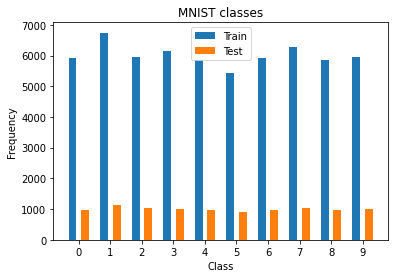

In [7]:
labels = ["%s"%i for i in range(10)]

unique, counts = np.unique(y_train_ori, return_counts=True)
uniquet, countst = np.unique(y_test_ori, return_counts=True)

fig, ax = plt.subplots()
rects1 = ax.bar(unique - 0.2, counts, 0.25, label='Train')
rects2 = ax.bar(unique + 0.2, countst, 0.25, label='Test')
ax.legend()
ax.set_xticks(unique)
ax.set_xticklabels(labels)

plt.title('MNIST classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

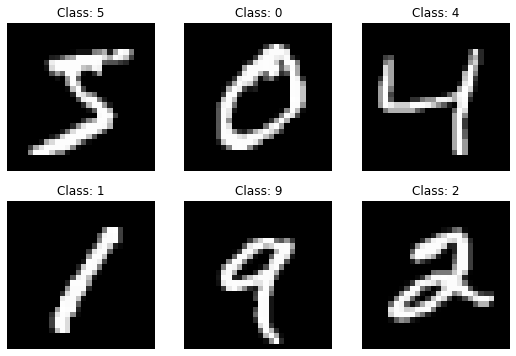

In [8]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))

for i in range(6):
    ax[i//3, i%3].imshow(X_train_ori[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_ori[i])
    
plt.show()

In [9]:
# Reduce the image size to its half 
X_train = np.array([image[::2, 1::2] for image in X_train_ori])
X_test  = np.array([image[::2, 1::2] for image in X_test_ori])

y_train = y_train_ori
y_test = y_test_ori

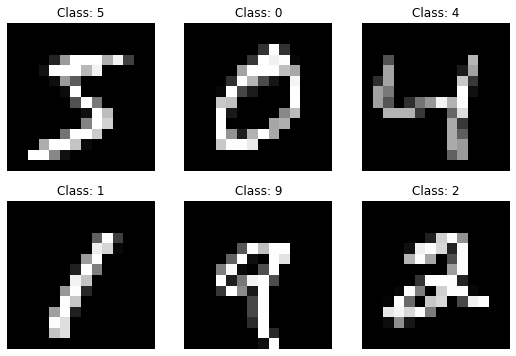

In [10]:
fig, ax = plt.subplots(2, 3, figsize = (9, 6))

for i in range(6):
    ax[i//3, i%3].imshow(X_train[i], cmap='gray')
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_title("Class: %d"%y_train_ori[i])
    
plt.show()

In [11]:
X_train = (X_train/255.0).astype('float32').reshape((60000,14*14))
X_test = (X_test/255.0).astype('float32').reshape((10000,14*14))

print(X_train.dtype)
print(X_test.dtype)

print("\nShape of X_train: ", X_train.shape)
print("Shape of X_test: ", X_test.shape)

print("\nMinimum value in X_train:", np.amin(X_train))
print("Maximum value in X_train:", np.amax(X_train))

print("\nMinimum value in X_test:", np.amin(X_test))
print("Maximum value in X_test:", np.amax(X_test))

float32
float32

Shape of X_train:  (60000, 196)
Shape of X_test:  (10000, 196)

Minimum value in X_train: 0.0
Maximum value in X_train: 1.0

Minimum value in X_test: 0.0
Maximum value in X_test: 1.0


---

# Solution

This part of the notebook contains the solution for EP4.

It's noticeable that there are repeated imports in multiple code cells. It was done in order to keep each section individually runnable, as some training parts take a long time to run. The only mandatory section is the first one, as it separates the training data and creates the variables `D_X_train`, `D_X_val`, `D_y_train` and `D_y_val`. After running the first section code, you should be able to run the other section independently.

## 0. Lib versions

In [12]:
print('numpy version:', np.__version__)

import matplotlib
print('matplotlib version:', matplotlib.__version__)
del matplotlib

import tensorflow
print('tensorflow version: ', tensorflow.__version__)
del tensorflow

import sklearn
print('scikit-learn version:', sklearn.__version__)
del sklearn

numpy version: 1.19.5
matplotlib version: 3.4.1
tensorflow version:  2.5.0
scikit-learn version: 0.24.2


## 1. Dataset preparation

In [13]:
from sklearn.model_selection import train_test_split

D_X_train, D_X_val, D_y_train, D_y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

print(D_X_train.shape)
print(D_X_val.shape)

print(D_y_train.shape)
print(D_y_val.shape)

(42000, 196)
(18000, 196)
(42000,)
(18000,)


In [14]:
def print_distribution(y_train, y_test, train_label, test_label):
    """
    Plots distribution of train and test answers
    :param y_train: answers for train set
    :type y_train: np.ndarray(shape=(M,))
    :param y_test: answers for test set
    :type y_test: np.ndarray(shape=(N,))
    :param train_label: label shown for train set 
    :type train_label: str
    :param test_label: label shown for test set 
    :type test_label: str
    :return: nothing
    :rtype: None
    """

    labels = ["%s"%i for i in range(10)]

    unique, counts = np.unique(y_train, return_counts=True)
    uniquet, countst = np.unique(y_test, return_counts=True)

    fig, ax = plt.subplots()
    rects1 = ax.bar(unique - 0.2, counts, 0.25, label=train_label)
    rects2 = ax.bar(unique + 0.2, countst, 0.25, label=test_label)
    ax.legend()
    ax.set_xticks(unique)
    ax.set_xticklabels(labels)

    plt.title('MNIST classes')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.show()

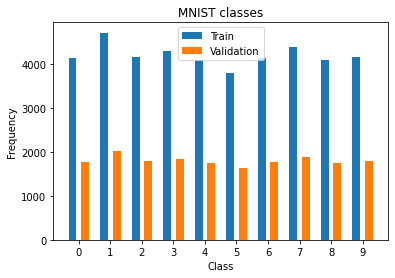

In [15]:
print_distribution(D_y_train, D_y_val, 'Train', 'Validation')

## 2. Training, evaluating and selecting models

### 2.1 Logistic regression

To train and evaluate a model using Logistic Regression, the method [LogisticRegressionCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html) was used. It implements the Logistic Regression function along with the Cross Validation Technique. It also applies regularization by default.

The hyperparameter is `C`, which is the inverse of the regularization strength (which we've seen in class as $\lambda$). The values chosen to be tested were `[0.01, 0.1, 1, 10, 100]`.

The Cross Validation technique applied is a Stratified K-fold with 5 folds.

The iterations number was increased due to multiple no conversion warnings with default value (`100` iterations).

After fitting the data, **the chosen `C` value was `10`**, with an **accuracy of approx. 91.73%**.

The decisions for this sections were taken based on the following articles from scikit-learn documentation: [about Logistic Regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), [LogisticRegression method docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), [LogisticRegressionCV method docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html), [the whole section about model selection](https://scikit-learn.org/stable/model_selection.html) and usage examples such as [this one](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sparse_logistic_regression_mnist.html).

In [27]:
from sklearn.linear_model import LogisticRegressionCV

import warnings
warnings.filterwarnings('ignore') # ignores ConvergenceWarning

logistic_regression_model = LogisticRegressionCV(
    Cs=[0.01, 0.1, 1, 10, 100],
    cv=5,
    max_iter=1000,
    random_state=42
).fit(D_X_train, D_y_train)

warnings.filterwarnings('default') # reestablish warnings

In [33]:
print('Score for Logistic Regression model:', logistic_regression_model.score(D_X_train, D_y_train))
print('Chosen C parameter:', logistic_regression_model.C_)

Score for Logistic Regression model: 0.9172857142857143
Chosen C parameter: [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


/usr/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2.2 Neural network

To train and evaluate a model using Neural Networks, the method [MLPClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) was used, along with the [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html). The former implements a multi-layer perceptron neural network (with regularization). The latter receives the defined neural network object (it could be other techniques from scikit-learn) and trains it with multiple combinations of the given hyperparameters, in order to find the combination with highest score (in this case, accuracy). This particular model selector randomly chooses the next permutation to test, and tries to eliminate some of the possibilities. Although it makes the training part faster, there might be an eliminated permutation that performs better than the chosen one.

The hyperparameter are:
- `activation (default value: 'relu')`: activation function for the hidden layer;
- `alpha (default value: 0.0001)`: L2 penalty (regularization term) parameter;
- `hidden_later_sizes (default value:(100,))`: the ith element represents the number of neurons in the ith hidden layer.;
- `learning_rate_init (default value: 0.001)`: the initial learning rate used. It controls the step-size in updating the weights.;
- `max_iter (default value: 200)`: Maximum number of iterations. The solver iterates until convergence.

The values were based on examples such as: (1)[https://johdev.com/jupyter/2020/03/02/Sklearn_MLP_for_MNIST.html] and (2)[https://nasirml.wordpress.com/2017/12/16/multi-layer-perceptron-in-tensorflow-part-2-mnist/]

The Cross Validation technique applied is a Stratified K-fold with 5 folds.

After fitting the data, the chosen values were **`{'max_iter': 200, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (196,), 'alpha': 0.001, 'activation': 'relu'}`** with an **accuracy of approx. 96.67%**.

Other material used: documentation about [neural networks](https://scikit-learn.org/stable/modules/neural_networks_supervised.html) and [grid search](https://scikit-learn.org/stable/modules/grid_search.html).

In [24]:
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV

import warnings
warnings.filterwarnings('ignore') # ignores ConvergenceWarning

param_grid = {
    'hidden_layer_sizes': [(10,), (100,), (196,), (196, 98)],
    'activation': ['tanh', 'relu'],
    'alpha': [1e-3, 1e-4, 1e-5],
    'learning_rate_init': [0.1, 0.01, 0.001],
    'max_iter': [10, 50, 100, 200],
}
base_neural_network = MLPClassifier(early_stopping=True, random_state=42)
sh = HalvingRandomSearchCV(base_neural_network, param_grid, random_state=42).fit(D_X_train, D_y_train)

warnings.filterwarnings('default') # reestablish warnings

In [26]:
print('Score for Neural Network model', sh.best_score_)
print('Selected params:', sh.best_params_)

Score for Neural Network model 0.9667489711934157
Selected params: {'max_iter': 200, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (196,), 'alpha': 0.001, 'activation': 'relu'}


### 2.3 SVM

To train and evaluate a model using SVM, the method [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) was used, along with the [HalvingRandomSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.HalvingRandomSearchCV.html). The former implements a C-Support Vector Classification (with regularization). The latter is the same used at the section above.

The hyperparameter are:
- `C (default value: '1.0')`: regularization parameter. The strength of the regularization is inversely proportional to C. Must be strictly positive. The penalty is a squared l2 penalty;
- `gamma (default value: 'scale')`: kernel coefficient;
- `decision_function_shape (default value: 'ovr')`: whether to return a one-vs-rest (‘ovr’) decision function of shape (n_samples, n_classes) as all other classifiers, or the original one-vs-one (‘ovo’) decision function of libsvm which has shape (n_samples, n_classes * (n_classes - 1) / 2).

The Cross Validation technique applied is a Stratified K-fold with 5 folds.

After fitting the data, the chosen values were **`{'C': 10, 'decision_function_shape': 'ovo', 'gamma': 'scale'}`** with an **accuracy of approx. 97.59%**.

Other material used: documentation about [SVM](https://scikit-learn.org/stable/modules/svm.html)

In [23]:
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 1, 0.5, 0.01, 0.001],
    'decision_function_shape': ['ovo', 'ovr'],
}
base_svm = SVC(random_state=42)
sh = HalvingGridSearchCV(base_svm, param_grid).fit(D_X_train, D_y_train)

In [24]:
print('Score for SVM model', sh.best_score_)
print('Selected params:', sh.best_params_)

Score for SVM model 0.9758961533881149
Selected params: {'C': 10, 'decision_function_shape': 'ovo', 'gamma': 'scale'}


## 3. Choosing a final model

In this section, models will be created with the selected hyperparameters from previous section. Then, they will be trained with the whole `D_train` set, tested with `D_val`, and compared.

Analysis and some code based on [this example from scikit-learn docs](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html).

### 3.1 Logistic Regression Model

In [14]:
from sklearn.linear_model import LogisticRegression

logistic_regression_model = LogisticRegression(
    C=10,
    max_iter=1000,
    random_state=42).fit(D_X_train, D_y_train)

In [15]:
from sklearn.metrics import classification_report

predictions_logistic_regression = logistic_regression_model.predict(D_X_val)

print(classification_report(D_y_val, predictions_logistic_regression, digits=4))

              precision    recall  f1-score   support

           0     0.9447    0.9702    0.9572      1777
           1     0.9417    0.9669    0.9541      2023
           2     0.9054    0.8842    0.8947      1787
           3     0.8985    0.8662    0.8821      1839
           4     0.9085    0.9059    0.9072      1753
           5     0.8718    0.8739    0.8729      1626
           6     0.9431    0.9532    0.9482      1775
           7     0.9353    0.9154    0.9253      1880
           8     0.8781    0.8661    0.8721      1755
           9     0.8650    0.8902    0.8774      1785

    accuracy                         0.9102     18000
   macro avg     0.9092    0.9092    0.9091     18000
weighted avg     0.9101    0.9102    0.9100     18000



In [33]:
from sklearn.metrics import r2_score

r2_score(D_y_val, predictions_logistic_regression)

0.8141318612972092

[]

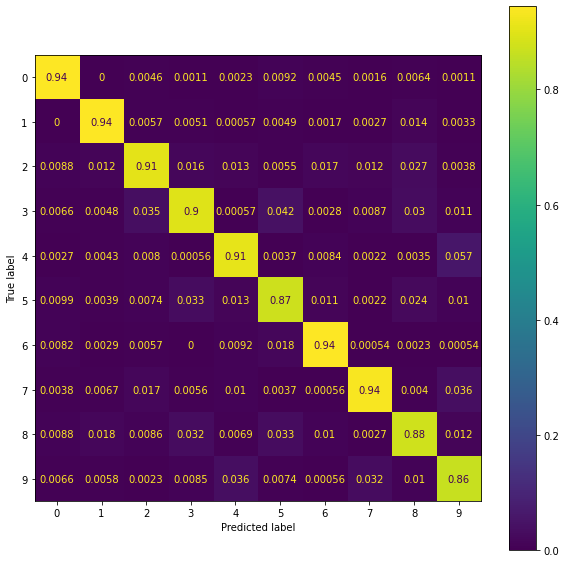

In [31]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(logistic_regression_model, D_X_val, D_y_val, normalize='pred', ax=ax)
plt.plot()

### 3.2 Neural Network Model

In [40]:
from sklearn.neural_network import MLPClassifier

neural_network_model = MLPClassifier(
    activation='relu',
    alpha=0.001,
    early_stopping=True,
    hidden_layer_sizes=(196,),
    learning_rate_init=0.01,
    random_state=42).fit(D_X_train, D_y_train)

/usr/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
from sklearn.metrics import classification_report

predictions_neural_network = neural_network_model.predict(D_X_val)

print(classification_report(D_y_val, predictions_neural_network, digits=4))

              precision    recall  f1-score   support

           0     0.9761    0.9865    0.9812      1777
           1     0.9837    0.9847    0.9842      2023
           2     0.9588    0.9765    0.9676      1787
           3     0.9486    0.9636    0.9560      1839
           4     0.9725    0.9698    0.9712      1753
           5     0.9675    0.9508    0.9591      1626
           6     0.9743    0.9831    0.9787      1775
           7     0.9773    0.9601    0.9686      1880
           8     0.9729    0.9413    0.9568      1755
           9     0.9497    0.9625    0.9560      1785

    accuracy                         0.9682     18000
   macro avg     0.9681    0.9679    0.9679     18000
weighted avg     0.9683    0.9682    0.9682     18000



In [34]:
from sklearn.metrics import r2_score

r2_score(D_y_val, predictions_neural_network)

0.9325870302520848

[]

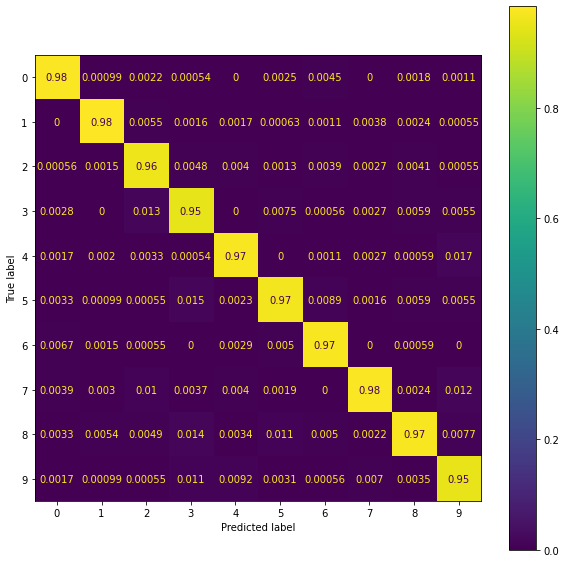

In [30]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(neural_network_model, D_X_val, D_y_val, normalize='pred', ax=ax)
plt.plot()

### 3.3 Training the SVM Model

In [38]:
from sklearn.svm import SVC

svm_model = SVC(
    C=10,
    decision_function_shape='ovo',
    random_state=42).fit(D_X_train, D_y_train)

/usr/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
from sklearn.metrics import classification_report

predictions_svm = svm_model.predict(D_X_val)

print(classification_report(D_y_val, predictions_svm, digits=4))

              precision    recall  f1-score   support

           0     0.9790    0.9949    0.9869      1777
           1     0.9795    0.9921    0.9858      2023
           2     0.9755    0.9810    0.9782      1787
           3     0.9867    0.9695    0.9781      1839
           4     0.9794    0.9778    0.9786      1753
           5     0.9820    0.9736    0.9778      1626
           6     0.9870    0.9842    0.9856      1775
           7     0.9802    0.9766    0.9784      1880
           8     0.9737    0.9721    0.9729      1755
           9     0.9697    0.9692    0.9695      1785

    accuracy                         0.9793     18000
   macro avg     0.9793    0.9791    0.9792     18000
weighted avg     0.9793    0.9793    0.9793     18000



In [35]:
from sklearn.metrics import r2_score

r2_score(D_y_val, predictions_svm)

0.9549870357971473

[]

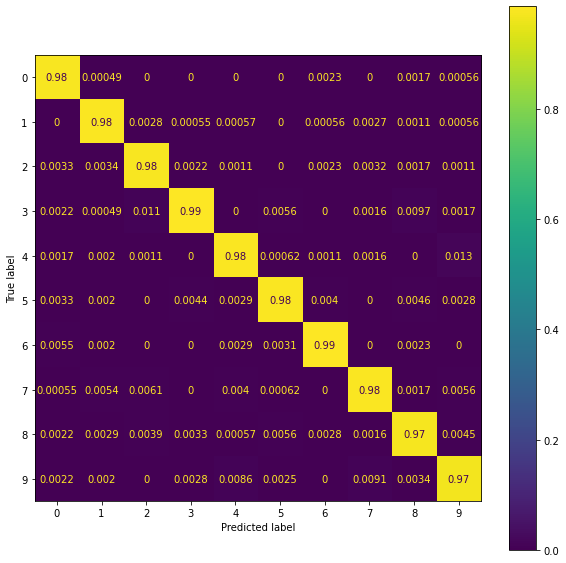

In [32]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(svm_model, D_X_val, D_y_val, normalize='pred', ax=ax)
plt.plot()

### 3.4 Choosing a model

Based on the shown results, the **SVM** is the chosen model.

The linear model - Logistic Regression - presents the lowest accuracy, with an average of about _91%_. Both the Neural Network and the SVM models' performances are better, with _97%_ and _98%_ average accuracy respectively. Therefore, the SVM model wins with a slight advantage over the Neural Network model.

Also, all the models performed similarly to their training scores, which shows that the regularization techniques had an impact on overfitting.

As a curiosity: all models had their lowest accuracy when trying to predict the digit nine.

## 4. Error estimation

In this section, the SVM model will be trained twice: once with only $D_{train}$ and then with the whole training set. Each time, its performance will be analysed using the testing set.

### 4.1 With only $D_{train}$ data

In [43]:
from sklearn.svm import SVC

svm_model = SVC(
    C=10,
    decision_function_shape='ovo',
    random_state=42)

In [39]:
svm_model.fit(D_X_train, D_y_train)

/usr/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


SVC(C=10, decision_function_shape='ovo', random_state=42)

In [45]:
test_1_predictions = svm_model.predict(X_test)

In [46]:
from sklearn.metrics import classification_report

print(classification_report(y_test, test_1_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9749    0.9908    0.9828       980
           1     0.9878    0.9947    0.9912      1135
           2     0.9787    0.9787    0.9787      1032
           3     0.9802    0.9802    0.9802      1010
           4     0.9757    0.9817    0.9787       982
           5     0.9831    0.9787    0.9809       892
           6     0.9822    0.9770    0.9796       958
           7     0.9775    0.9708    0.9741      1028
           8     0.9793    0.9733    0.9763       974
           9     0.9710    0.9633    0.9672      1009

    accuracy                         0.9791     10000
   macro avg     0.9790    0.9789    0.9790     10000
weighted avg     0.9791    0.9791    0.9791     10000



In [52]:
from sklearn.metrics import r2_score

r2_score(y_test, test_1_predictions)

0.9462505138400789

[]

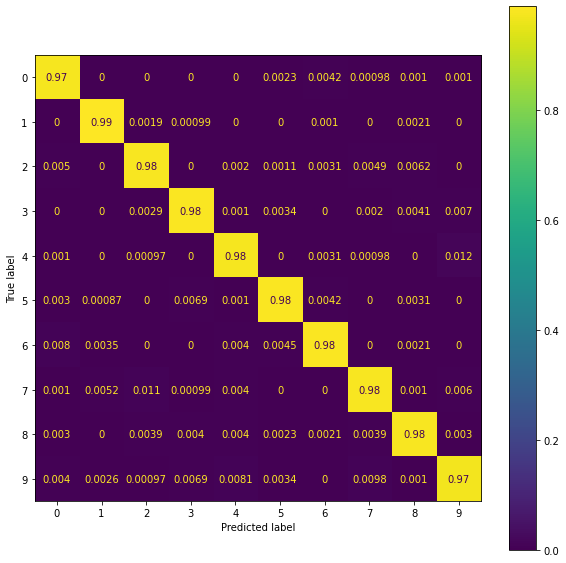

In [41]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(svm_model, X_test, y_test, normalize='pred', ax=ax)
plt.plot()

### 4.2 With all training data

In [47]:
svm_model.fit(X_train, y_train)
test_2_predictions = svm_model.predict(X_test)

[LibSVM]

In [49]:
from sklearn.metrics import classification_report

print(classification_report(y_test, test_2_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9809    0.9939    0.9873       980
           1     0.9895    0.9956    0.9925      1135
           2     0.9778    0.9826    0.9802      1032
           3     0.9793    0.9822    0.9807      1010
           4     0.9817    0.9847    0.9832       982
           5     0.9809    0.9776    0.9792       892
           6     0.9895    0.9833    0.9864       958
           7     0.9794    0.9728    0.9761      1028
           8     0.9774    0.9764    0.9769       974
           9     0.9779    0.9643    0.9711      1009

    accuracy                         0.9815     10000
   macro avg     0.9814    0.9813    0.9814     10000
weighted avg     0.9815    0.9815    0.9815     10000



In [51]:
from sklearn.metrics import r2_score

r2_score(y_test, test_2_predictions)

0.9561131331110473

[]

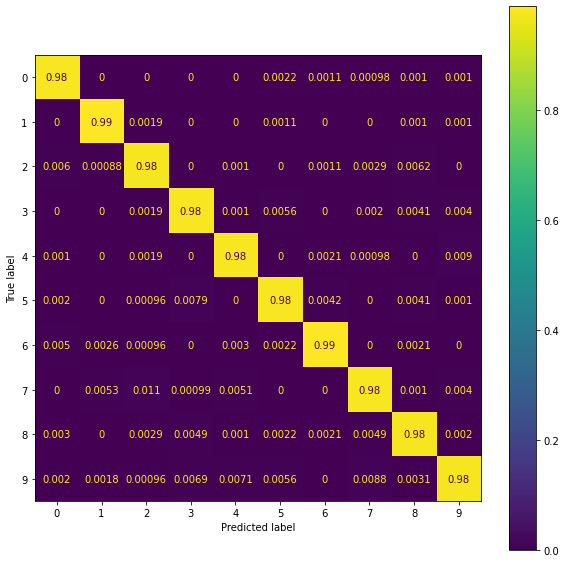

In [53]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(svm_model, X_test, y_test, normalize='pred', ax=ax)
plt.plot()

### 4.3 Conclusion

After analysing the reports and metrics, it's possible to conclude that the model continues to predict the results accordingly.

Its performance when predicting the testing set results kept the same accuracy rate, with an average of approx. **98%**, only with an slightly lower R2 score - **0.946** instead of **0.955**.

When the whole training set was used, the performance improved a little. Furthermore, the R2 score returned to **0.956**.